<a href="https://colab.research.google.com/github/octavianus25/salim-1/blob/main/VGG19_Feature_Extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split-folders

In [ ]:
##reference
##https://towardsdatascience.com/step-by-step-vgg19-implementation-in-keras-for-beginners-a833c686ae6c
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg19

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_ds = '/content/drive/MyDrive/Tesis/DATASET TOMAT PALING BARU'
base_ds = pathlib.Path(base_ds)

In [ ]:
import splitfolders
splitfolders.ratio(base_ds, output='gambar', seed=123, ratio=(.70,.15,.15), group_prefix=None)

Copying files: 500 files [00:07, 65.99 files/s]


In [ ]:
Belum_Matang = [fn for fn in os.listdir(f'{base_ds}/Belum_Matang') if fn.endswith('.jpg')]
MatangGrade1 = [fn for fn in os.listdir(f'{base_ds}/MatangGrade1') if fn.endswith('.jpg')]
MatangGrade2 = [fn for fn in os.listdir(f'{base_ds}/MatangGrade2') if fn.endswith('.jpg')]
MatangGrade3 = [fn for fn in os.listdir(f'{base_ds}/MatangGrade3') if fn.endswith('.jpg')]
Busuk = [fn for fn in os.listdir(f'{base_ds}/Busuk') if fn.endswith('.jpg')]

tomato = [Belum_Matang, MatangGrade1, MatangGrade2, MatangGrade3, Busuk]
tomato_classes = []
for i in os.listdir('gambar/train'):
    tomato_classes+=[i]
    tomato_classes.sort()

Total images: 500
Total number of classes: 5
Total Belum_Matang images: 100
Total Busuk images: 100
Total MatangGrade1 images: 100
Total MatangGrade2 images: 100
Total MatangGrade3 images: 100


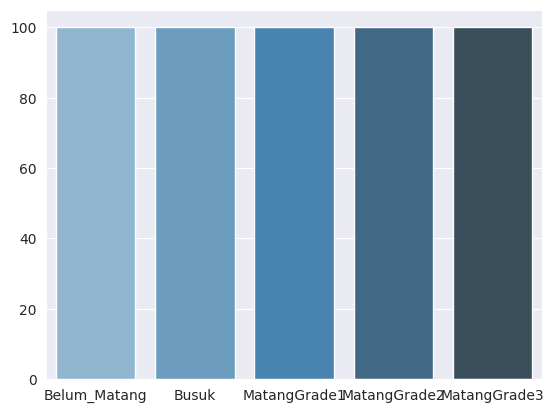

In [ ]:
image_count = len(list(base_ds.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(tomato_classes)}')
count = 0
tomato_count = []
for x in tomato_classes:
  print(f'Total {x} images: {len(tomato[count])}')
  tomato_count.append(len(tomato[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=tomato_classes, y=tomato_count, palette="Blues_d")
plt.show()

In [ ]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in tomato_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

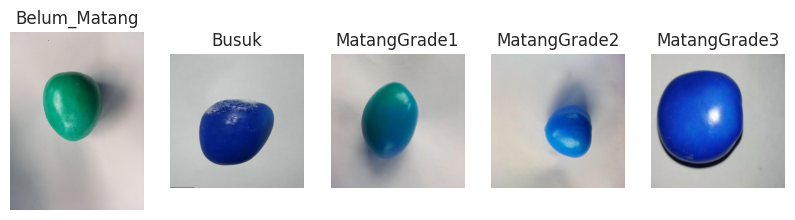

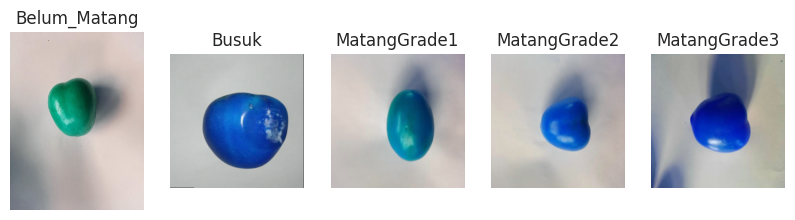

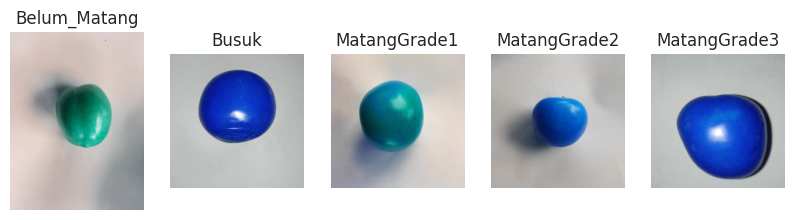

In [ ]:
for i in range(3):
  load_random_img(base_ds, tomato_classes)

In [ ]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_ds = datagen.flow_from_directory(
    'gambar/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'gambar/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'gambar/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 350 images belonging to 5 classes.
Found 75 images belonging to 5 classes.
Found 75 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
vgg19.trainable = False

inputs = tf.keras.Input(input_shape)
x = vgg19.output
x = tf.keras.layers.Flatten()(x)
model_vgg19 = tf.keras.layers.Dense(5, activation='softmax')(x)
model = tf.keras.models.Model(inputs=vgg19.input, outputs=model_vgg19)

In [ ]:
# COMPILE MODEL
from keras.optimizers import Adam
opt = Adam(lr=0.00001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# history1 = model_vgg19.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks=callbacks)/

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("VGG19.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=50, verbose=1, mode='auto')
hist = model.fit_generator(train_ds, validation_data= val_ds, steps_per_epoch=len(train_ds), validation_steps=len(val_ds),epochs=50,callbacks=[checkpoint,early])

<ipython-input-15-6c619fce064f>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_ds, validation_data= val_ds, steps_per_epoch=len(train_ds), validation_steps=len(val_ds),epochs=50,callbacks=[checkpoint,early])


Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.6783 - accuracy: 0.1914
Epoch 1: val_accuracy improved from -inf to 0.18667, saving model to VGG19.h5
11/11 [==============================] - 88s 7s/step - loss: 1.6783 - accuracy: 0.1914 - val_loss: 1.6256 - val_accuracy: 0.1867
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.5980 - accuracy: 0.2171
Epoch 2: val_accuracy improved from 0.18667 to 0.24000, saving model to VGG19.h5
11/11 [==============================] - 67s 6s/step - loss: 1.5980 - accuracy: 0.2171 - val_loss: 1.5772 - val_accuracy: 0.2400
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.5569 - accuracy: 0.2771
Epoch 3: val_accuracy improved from 0.24000 to 0.37333, saving model to VGG19.h5
11/11 [==============================] - 70s 7s/step - loss: 1.5569 - accuracy: 0.2771 - val_loss: 1.5447 - val_accuracy: 0.3733
Epoch 4/50
11/11 [==============================] - ETA: 0s - loss: 1.5261 - accuracy: 0.40

In [ ]:
score2 = model.evaluate(test_ds, verbose=1)
print(f'Model Cust VGG19 Loss: {score2[0]}, Accuracy: {score2[1]*100}')

3/3 [==============================] - 13s 136ms/step - loss: 0.8046 - accuracy: 0.8533
Model Cust VGG19 Loss: 0.8046388030052185, Accuracy: 85.33333539962769


In [ ]:
from sklearn.metrics import accuracy_score
true_classes = test_ds.classes
class_indices = train_ds.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model.predict(test_ds)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG19 Model Accuracy Test: {:.2f}%".format(vgg_acc * 100))

3/3 [==============================] - 13s 175ms/step
VGG19 Model Accuracy Test: 85.33%


#Graphic

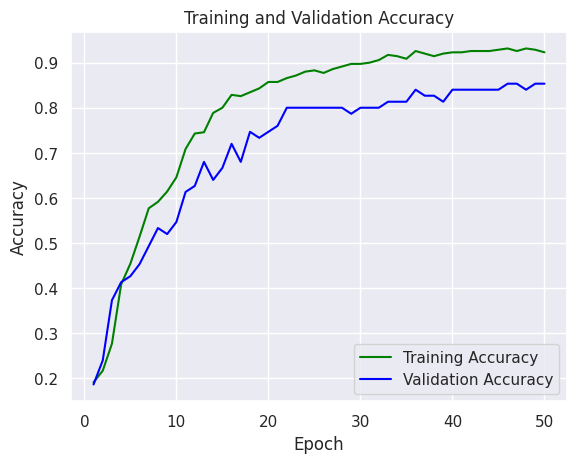

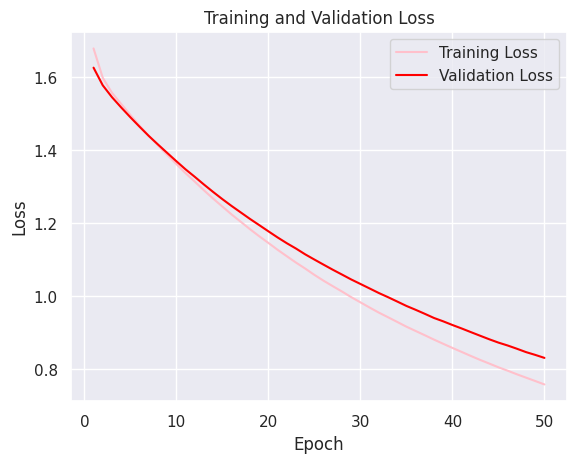

In [ ]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred,axis=1)

3/3 [==============================] - 12s 198ms/step


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Visualizing
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

Confusion matrix, without normalization


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

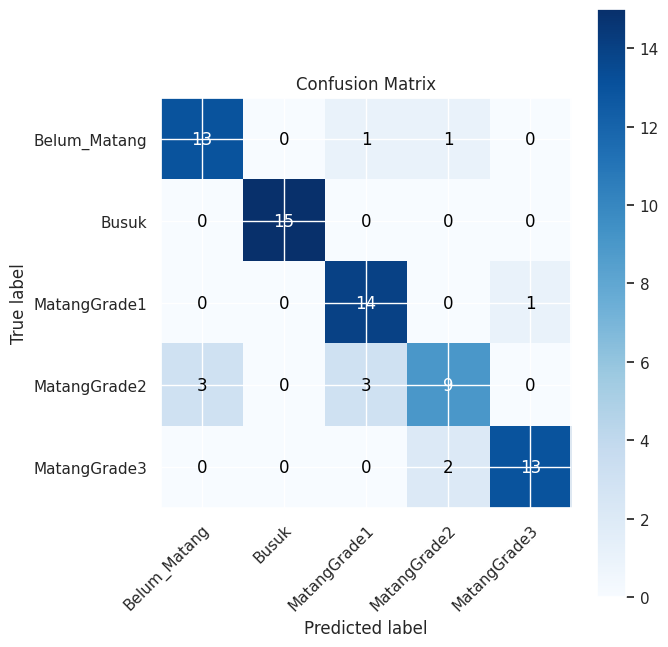

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# Get the names of the 5 classes
class_names = test_ds.class_indices.keys()
#Plotting non-normalized confusion matrix
plot_confusion_matrix(true_classes, vgg_pred_classes, classes = class_names,  title = 'Confusion Matrix')

In [ ]:
report1 = classification_report(test_ds.classes, y_pred, target_names=tomato_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
Belum_Matang,0.812500,0.866667,0.838710,15.000000
Busuk,1.000000,1.000000,1.000000,15.000000
MatangGrade1,0.777778,0.933333,0.848485,15.000000
MatangGrade2,0.750000,0.600000,0.666667,15.000000
MatangGrade3,0.928571,0.866667,0.896552,15.000000
accuracy,0.853333,0.853333,0.853333,0.853333
macro avg,0.853770,0.853333,0.850083,75.000000
weighted avg,0.853770,0.853333,0.850083,75.000000
